# Workshop: Model Evaluation and Statistical Inference

**Course:** Data Science for Mathematicians

**Workshop Focus:** Translating the theoretical framework of model evaluation into hands-on computation. We implement evaluation metrics from scratch using NumPy, construct confusion matrices, build ROC curves, and apply cross-validation to perform principled model selection.

**Key Concepts:**
* The Bias-Variance Tradeoff — visualizing underfitting vs. overfitting via polynomial regression.
* Regression Metrics: MSE, RMSE, $R^2$, Adjusted $R^2$ — implemented from first principles.
* Classification Metrics: Confusion Matrix, Precision, Recall, $F_1$-Score, $F_\beta$-Score — computed from scratch.
* The ROC Curve and AUC — constructed step-by-step.
* $k$-Fold Cross-Validation — implemented manually and verified with Scikit-learn.

**Datasets:**
* `medical_insurance.csv` — Regression task (predicting insurance charges).
* `sms_spam.csv` — Classification task (spam vs. ham detection with class imbalance).

***

## Section 0: Setup and Data Loading

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

### Question 0.1: Load and Inspect the Medical Insurance Dataset

Load `medical_insurance.csv` into a Pandas DataFrame. Display the first few rows, check for missing values, and report the shape of the dataset.

In [83]:
df_insurance = pd.read_csv('datasets/medical_insurance.csv')
print(f"Shape: {df_insurance.shape}")
print(f"Missing values:\n{df_insurance.isnull().sum()}")
df_insurance.head()

Shape: (2772, 7)
Missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

### Question 0.2: Load and Inspect the SMS Spam Dataset

Load `sms_spam.csv` into a Pandas DataFrame. Check the class distribution of `label` and compute the class imbalance ratio.

In [84]:
df_sms = pd.read_csv('datasets/sms_spam.csv')
print(f"Shape: {df_sms.shape}")
print(f"\nClass distribution:")
print(df_sms['label'].value_counts())

n_ham = (df_sms['label'] == 'ham').sum()
n_spam = (df_sms['label'] == 'spam').sum()
print(f"\nImbalance ratio (ham:spam): {n_ham/n_spam:.2f} : 1")
print(f"Spam proportion: {n_spam / len(df_sms):.4f}")
df_sms.head()

Shape: (10961, 2)

Class distribution:
label
ham     8555
spam    2406
Name: count, dtype: int64

Imbalance ratio (ham:spam): 3.56 : 1
Spam proportion: 0.2195


label                                            message
0  spam  Congratulations! You've been selected for a lu...
1  spam  URGENT: Your account has been compromised. Cli...
2  spam  You've won a free iPhone! Claim your prize by ...
3  spam  Act now and receive a 50% discount on all purc...
4  spam  Important notice: Your subscription will expir...

***

## Section 1: The Bias-Variance Tradeoff — A Visual Demonstration

**Theory Recap.** The Bias-Variance Decomposition states that the expected prediction error of an estimator $\hat{f}$ at a point $x_0$ is:

$$\mathbb{E}[(y_0 - \hat{f}(x_0))^2] = \underbrace{(\mathbb{E}[\hat{f}(x_0)] - f(x_0))^2}_{\text{Bias}^2} + \underbrace{\mathbb{E}[(\hat{f}(x_0) - \mathbb{E}[\hat{f}(x_0)])^2]}_{\text{Variance}} + \underbrace{\sigma^2}_{\text{Irreducible Error}}$$

As model complexity increases, bias decreases but variance increases. The total error follows a U-shaped curve, and the optimal complexity sits at its minimum.

### Question 1.1: Simulate the Bias-Variance Tradeoff

We will simulate the decomposition empirically:
1. Define a true function $f(x) = \sin(\pi x)$ with additive Gaussian noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
2. Repeatedly draw training datasets and fit polynomial models of degrees $d = 1, 3, 5, 10, 15$.
3. At a fixed test point $x_0$, estimate $\text{Bias}^2$, $\text{Variance}$, and total error over the simulations.
4. Plot the results to visualize the tradeoff.

In [85]:
# True function and noise level
f_true = lambda x: np.sin(np.pi * x)
sigma = 0.3

# Simulation parameters
n_train = 25           # training set size per simulation
n_simulations = 200    # number of repeated experiments
x0 = 0.7               # fixed test point
degrees = [1, 3, 5, 10, 15]

results = {'degree': [], 'bias_sq': [], 'variance': [], 'total_error': []}

for d in degrees:
    predictions_at_x0 = []
    
    for sim in range(n_simulations):
        # Draw a random training set
        x_train = np.random.uniform(0, 2, n_train)
        y_train = f_true(x_train) + np.random.normal(0, sigma, n_train)
        
        # Fit polynomial of degree d
        coeffs = np.polyfit(x_train, y_train, d)
        poly = np.poly1d(coeffs)
        
        # Record prediction at x0
        predictions_at_x0.append(poly(x0))
    
    predictions_at_x0 = np.array(predictions_at_x0)
    
    # Compute Bias^2 and Variance
    f_x0 = f_true(x0)
    mean_pred = np.mean(predictions_at_x0)
    bias_sq = (mean_pred - f_x0) ** 2
    variance = np.var(predictions_at_x0)
    total_error = bias_sq + variance + sigma**2
    
    results['degree'].append(d)
    results['bias_sq'].append(bias_sq)
    results['variance'].append(variance)
    results['total_error'].append(total_error)
    
    print(f"Degree {d:2d}: Bias^2 = {bias_sq:.4f}, Variance = {variance:.4f}, "
          f"Irreducible = {sigma**2:.4f}, Total = {total_error:.4f}")

Degree  1: Bias^2 = 0.2639, Variance = 0.0152, Irreducible = 0.0900, Total = 0.3691
Degree  3: Bias^2 = 0.0049, Variance = 0.0141, Irreducible = 0.0900, Total = 0.1090
Degree  5: Bias^2 = 0.0000, Variance = 0.0174, Irreducible = 0.0900, Total = 0.1074
Degree 10: Bias^2 = 0.0000, Variance = 0.0528, Irreducible = 0.0900, Total = 0.1428
Degree 15: Bias^2 = 0.0029, Variance = 0.2626, Irreducible = 0.0900, Total = 0.3554


/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/2446841336.py:22: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_train, y_train, d)


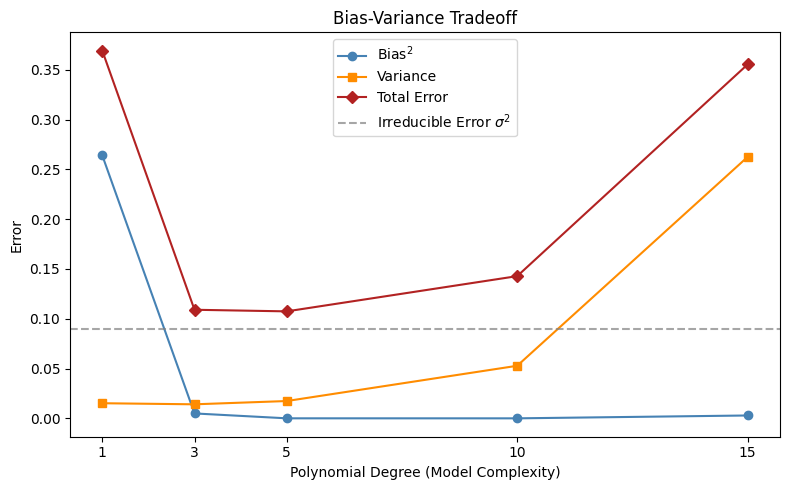

In [86]:
# Plot the Bias-Variance tradeoff
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(results['degree'], results['bias_sq'], 'o-', label=r'Bias$^2$', color='steelblue')
ax.plot(results['degree'], results['variance'], 's-', label='Variance', color='darkorange')
ax.plot(results['degree'], results['total_error'], 'D-', label='Total Error', color='firebrick')
ax.axhline(y=sigma**2, linestyle='--', color='gray', alpha=0.7, label=r'Irreducible Error $\sigma^2$')
ax.set_xlabel('Polynomial Degree (Model Complexity)')
ax.set_ylabel('Error')
ax.set_title('Bias-Variance Tradeoff')
ax.legend()
ax.set_xticks(degrees)
plt.tight_layout()
plt.show()

**Interpretation:** As the polynomial degree increases, $\text{Bias}^2$ decreases (the model becomes flexible enough to approximate the true function) while $\text{Variance}$ increases (the model becomes sensitive to the particular training sample). The total error has a U-shape, confirming the bias-variance tradeoff. The optimal degree sits at the minimum of the total error curve.

***

## Section 2: Regression Metrics — From Scratch

**Theory Recap.** Given observations $(y_i)$ and predictions $(\hat{y}_i)$:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2, \qquad \text{RMSE} = \sqrt{\text{MSE}}$$

$$R^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}}, \qquad R^2_{\text{adj}} = 1 - \frac{(1-R^2)(n-1)}{n-p-1}$$

where $\text{SS}_{\text{res}} = \sum(y_i - \hat{y}_i)^2$ and $\text{SS}_{\text{tot}} = \sum(y_i - \bar{y})^2$.

### Question 2.1: Fit a Linear Regression Model to the Insurance Data

Use `age` and `bmi` as predictors ($X$) to predict `charges` ($y$). Use Scikit-learn's `LinearRegression` to fit the model. Split the data into 80% training and 20% test sets using `train_test_split`.

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare features and target
X_raw = df_insurance[['age', 'bmi']].values
y = df_insurance['charges'].values
n = len(y)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

# Also store the split indices for later use
train_idx = np.where(np.isin(np.arange(n), 
    train_test_split(np.arange(n), test_size=0.2, random_state=42)[0]))[0]
test_idx = np.where(~np.isin(np.arange(n), train_idx))[0]

# Fit linear regression with sklearn
reg = LinearRegression()
reg.fit(X_train, y_train)

print(f"Training set size: {len(y_train)}")
print(f"Test set size:     {len(y_test)}")
print(f"\nOLS Coefficients:")
print(f"  Intercept (beta_0): {reg.intercept_:.4f}")
print(f"  Age       (beta_1): {reg.coef_[0]:.4f}")
print(f"  BMI       (beta_2): {reg.coef_[1]:.4f}")

# Generate predictions
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

Training set size: 2217
Test set size:     555

OLS Coefficients:
  Intercept (beta_0): -5455.0999
  Age       (beta_1): 229.3271
  BMI       (beta_2): 319.4340


/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib

### Question 2.2: Compute MSE, RMSE, $R^2$, and Adjusted $R^2$ from Scratch

Implement each metric using only NumPy operations. Compute them on both the training and test sets. Compare training vs. test performance.

In [88]:
def compute_mse(y_true, y_pred):
    """MSE = (1/n) * sum((y_i - y_hat_i)^2)"""
    return np.mean((y_true - y_pred) ** 2)

def compute_r2(y_true, y_pred):
    """R^2 = 1 - SS_res / SS_tot"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def compute_adj_r2(y_true, y_pred, p):
    """R^2_adj = 1 - (1 - R^2)(n-1) / (n-p-1)"""
    r2 = compute_r2(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Number of predictors (excluding intercept)
p = 2

# Training metrics
mse_train = compute_mse(y_train, y_pred_train)
r2_train = compute_r2(y_train, y_pred_train)
adj_r2_train = compute_adj_r2(y_train, y_pred_train, p)

# Test metrics
mse_test = compute_mse(y_test, y_pred_test)
r2_test = compute_r2(y_test, y_pred_test)
adj_r2_test = compute_adj_r2(y_test, y_pred_test, p)

print(f"{'Metric':<20} {'Training':>12} {'Test':>12}")
print("-" * 46)
print(f"{'MSE':<20} {mse_train:>12,.2f} {mse_test:>12,.2f}")
print(f"{'RMSE':<20} {np.sqrt(mse_train):>12,.2f} {np.sqrt(mse_test):>12,.2f}")
print(f"{'R^2':<20} {r2_train:>12.4f} {r2_test:>12.4f}")
print(f"{'Adj. R^2':<20} {adj_r2_train:>12.4f} {adj_r2_test:>12.4f}")

Metric                   Training         Test
----------------------------------------------
MSE                  130,609,721.97 129,396,464.58
RMSE                    11,428.46    11,375.26
R^2                        0.1059       0.1569
Adj. R^2                   0.1051       0.1539


**Interpretation:** The RMSE is in the same units as the target variable (dollars), so it represents the typical magnitude of prediction error. The $R^2$ value represents the fraction of variance in charges explained by age and BMI alone. Note that training metrics are typically more optimistic than test metrics — this gap is precisely the overfitting phenomenon discussed in the lecture.

### Question 2.3: Verify Metrics with Scikit-learn

Use `sklearn.metrics` to verify that your from-scratch metric implementations match the library's results.

In [89]:
from sklearn.metrics import mean_squared_error, r2_score

mse_sk = mean_squared_error(y_test, y_pred_test)
r2_sk = r2_score(y_test, y_pred_test)

print(f"Test MSE  (from scratch): {mse_test:,.2f}")
print(f"Test MSE  (sklearn):      {mse_sk:,.2f}")
print(f"Match: {np.isclose(mse_test, mse_sk)}")
print()
print(f"Test R^2  (from scratch): {r2_test:.4f}")
print(f"Test R^2  (sklearn):      {r2_sk:.4f}")
print(f"Match: {np.isclose(r2_test, r2_sk)}")

Test MSE  (from scratch): 129,396,464.58
Test MSE  (sklearn):      129,396,464.58
Match: True

Test R^2  (from scratch): 0.1569
Test R^2  (sklearn):      0.1569
Match: True


### Question 2.4: Demonstrating that $R^2$ is Non-Decreasing with Added Predictors

The lecture proved that $R^2$ can never decrease when a new predictor is added to a linear model. Verify this empirically by fitting models with 1, 2, 3, and 4 features from the insurance dataset. Also compute Adjusted $R^2$ to see how the penalty behaves.

In [90]:
# Encode 'smoker' as 0/1 for use as a numeric predictor
smoker_encoded = (df_insurance['smoker'] == 'yes').astype(int).values

feature_sets = [
    (['age'], df_insurance[['age']].values),
    (['age', 'bmi'], df_insurance[['age', 'bmi']].values),
    (['age', 'bmi', 'children'], df_insurance[['age', 'bmi', 'children']].values),
    (['age', 'bmi', 'children', 'smoker'], 
     np.column_stack([df_insurance[['age', 'bmi', 'children']].values, smoker_encoded])),
]

print(f"{'Features':<35} {'p':>3} {'R^2 (train)':>12} {'Adj R^2 (train)':>16}")
print("-" * 70)

for feat_names, X_feat in feature_sets:
    p_feat = X_feat.shape[1]
    
    # Use only training indices
    X_tr = X_feat[train_idx]
    y_tr = y[train_idx]
    
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_tr)
    
    r2 = compute_r2(y_tr, y_hat)
    adj_r2 = compute_adj_r2(y_tr, y_hat, p_feat)
    
    label = ', '.join(feat_names)
    print(f"{label:<35} {p_feat:>3} {r2:>12.4f} {adj_r2:>16.4f}")

Features                              p  R^2 (train)  Adj R^2 (train)
----------------------------------------------------------------------
age                                   1       0.0803           0.0799
age, bmi                              2       0.1059           0.1051
age, bmi, children                    3       0.1092           0.1080
age, bmi, children, smoker            4       0.7522           0.7517


/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib

**Interpretation:** Observe that $R^2$ is strictly non-decreasing as we add predictors — confirming the lemma from the lecture. The Adjusted $R^2$ penalizes model complexity: it will only increase if the new predictor reduces $\text{SS}_{\text{res}}$ sufficiently to overcome the degrees-of-freedom penalty.

***

## Section 3: Classification Metrics — From Scratch

**Theory Recap.** The confusion matrix partitions $n$ predictions into four counts:

$$\text{TP} + \text{TN} + \text{FP} + \text{FN} = n$$

From these we derive:

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}, \qquad \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \qquad F_1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

We will use the SMS spam dataset to build a simple classifier and then evaluate it using these metrics.

### Question 3.1: Build a Spam Classifier with Naive Bayes

We build a text classifier using the Naive Bayes model — a natural choice given its probabilistic foundation (covered in Lesson 3). Instead of hand-crafting numerical features, we use Scikit-learn's `CountVectorizer` to convert raw message text into a bag-of-words representation: each message becomes a vector of word counts. This high-dimensional, sparse feature matrix is then fed to a `MultinomialNB` classifier, which models word frequencies under a multinomial distribution.

1. Encode labels as binary: `spam = 1`, `ham = 0`.
2. Split into 80/20 train/test.
3. Fit a `CountVectorizer` on the training messages to build the vocabulary and transform both sets.
4. Train a Multinomial Naive Bayes classifier on the word-count features.

In [91]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# 1. Encode labels
y_sms = (df_sms['label'] == 'spam').astype(int).values
messages = df_sms['message'].values

# 2. Train/test split (split raw text, vectorize after)
msg_train, msg_test, y_sms_train, y_sms_test = train_test_split(
    messages, y_sms, test_size=0.2, random_state=42, stratify=y_sms
)

# 3. Fit CountVectorizer on training data only, then transform both sets
vectorizer = CountVectorizer()
X_sms_train = vectorizer.fit_transform(msg_train)
X_sms_test = vectorizer.transform(msg_test)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Training matrix shape: {X_sms_train.shape}  (sparse, "
      f"{X_sms_train.nnz} non-zero entries)")

# 4. Train Multinomial Naive Bayes
clf = BernoulliNB()
clf.fit(X_sms_train, y_sms_train)

# Get predictions and probability scores
y_sms_pred = clf.predict(X_sms_test)
y_sms_scores = clf.predict_proba(X_sms_test)[:, 1]  # P(spam)

print(f"\nTraining samples: {len(y_sms_train)}")
print(f"Test samples:     {len(y_sms_test)}")
print(f"Test spam count:  {y_sms_test.sum()}")
print(f"Test ham count:   {(1 - y_sms_test).sum()}")

Vocabulary size: 47544
Training matrix shape: (8768, 47544)  (sparse, 424649 non-zero entries)

Training samples: 8768
Test samples:     2193
Test spam count:  481
Test ham count:   1712


### Question 3.2: Build the Confusion Matrix from Scratch

Using only NumPy, compute TP, TN, FP, FN from the true labels `y_sms_test` and predictions `y_sms_pred`. Verify the partition property: $\text{TP} + \text{TN} + \text{FP} + \text{FN} = n$.

In [92]:
def confusion_matrix_scratch(y_true, y_pred):
    """Compute TP, TN, FP, FN from binary labels."""
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, TN, FP, FN

TP, TN, FP, FN = confusion_matrix_scratch(y_sms_test, y_sms_pred)

print(f"Confusion Matrix:")
print(f"                  Predicted Spam   Predicted Ham")
print(f"  Actual Spam       TP = {TP:<10d}   FN = {FN}")
print(f"  Actual Ham        FP = {FP:<10d}   TN = {TN}")
print(f"\nPartition check: TP + TN + FP + FN = {TP + TN + FP + FN} = n = {len(y_sms_test)}")

Confusion Matrix:
                  Predicted Spam   Predicted Ham
  Actual Spam       TP = 190          FN = 291
  Actual Ham        FP = 32           TN = 1680

Partition check: TP + TN + FP + FN = 2193 = n = 2193


### Question 3.3: Compute Accuracy, Precision, Recall, and $F_1$-Score from Scratch

Implement each metric using the TP, TN, FP, FN values. Then compute the $F_\beta$-Score for $\beta = 2$ (recall-emphasized) and $\beta = 0.5$ (precision-emphasized).

In [93]:
# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision = TP / (TP + FP)
precision = TP / (TP + FP)

# Recall = TP / (TP + FN)
recall = TP / (TP + FN)

# F1 = 2 * Precision * Recall / (Precision + Recall)
f1 = 2 * precision * recall / (precision + recall)

# F_beta score
def f_beta_score(precision, recall, beta):
    return (1 + beta**2) * precision * recall / (beta**2 * precision + recall)

f2 = f_beta_score(precision, recall, beta=2)
f05 = f_beta_score(precision, recall, beta=0.5)

print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"F2-Score:       {f2:.4f}  (emphasizes recall)")
print(f"F0.5-Score:     {f05:.4f}  (emphasizes precision)")

Accuracy:       0.8527
Precision:      0.8559
Recall:         0.3950
F1-Score:       0.5405
F2-Score:       0.4427  (emphasizes recall)
F0.5-Score:     0.6939  (emphasizes precision)


**Interpretation:** For a spam filter, precision is critical — a false positive means a legitimate message is lost. The $F_{0.5}$-Score, which weighs precision more heavily, is the most appropriate single metric for this application. Conversely, for a medical screening test, recall is critical (we must not miss positive cases), making $F_2$ the better choice.

### Question 3.4: Verify with Scikit-learn

Use `sklearn.metrics` to verify the from-scratch confusion matrix, precision, recall, and $F_1$-score.

In [94]:
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score,
                             classification_report)

cm_sk = confusion_matrix(y_sms_test, y_sms_pred)
print("Sklearn Confusion Matrix:")
print(cm_sk)
print()

print(f"Sklearn Accuracy:  {accuracy_score(y_sms_test, y_sms_pred):.4f}")
print(f"Sklearn Precision: {precision_score(y_sms_test, y_sms_pred):.4f}")
print(f"Sklearn Recall:    {recall_score(y_sms_test, y_sms_pred):.4f}")
print(f"Sklearn F1:        {f1_score(y_sms_test, y_sms_pred):.4f}")
print()
print("Full Classification Report:")
print(classification_report(y_sms_test, y_sms_pred, target_names=['ham', 'spam']))

Sklearn Confusion Matrix:
[[1680   32]
 [ 291  190]]

Sklearn Accuracy:  0.8527
Sklearn Precision: 0.8559
Sklearn Recall:    0.3950
Sklearn F1:        0.5405

Full Classification Report:
              precision    recall  f1-score   support

         ham       0.85      0.98      0.91      1712
        spam       0.86      0.40      0.54       481

    accuracy                           0.85      2193
   macro avg       0.85      0.69      0.73      2193
weighted avg       0.85      0.85      0.83      2193



### Question 3.5: The Pitfall of Accuracy — A Baseline Comparison

The lecture warned that accuracy is misleading under class imbalance. Compute the accuracy of a *trivial classifier* that always predicts the majority class (`ham`). Compare it to our logistic regression model.

In [95]:
# Trivial classifier: always predict ham (0)
y_trivial = np.zeros_like(y_sms_test)

acc_trivial = np.mean(y_trivial == y_sms_test)
acc_model = accuracy

# Precision and recall of the trivial classifier
TP_t, TN_t, FP_t, FN_t = confusion_matrix_scratch(y_sms_test, y_trivial)

print(f"Trivial 'always ham' classifier:")
print(f"  Accuracy:  {acc_trivial:.4f}")
print(f"  Precision: undefined (TP + FP = 0, no positive predictions)")
print(f"  Recall:    {TP_t / (TP_t + FN_t) if (TP_t + FN_t) > 0 else 0:.4f}")
print(f"  F1-Score:  0.0000")
print()
print(f"Multinomial Naive Bayes classifier:")
print(f"  Accuracy:  {acc_model:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print()
print(f"The trivial classifier achieves {acc_trivial:.1%} accuracy by always")
print(f"predicting the majority class, yet has zero recall for spam.")
print(f"This demonstrates why accuracy alone is misleading for imbalanced data.")

Trivial 'always ham' classifier:
  Accuracy:  0.7807
  Precision: undefined (TP + FP = 0, no positive predictions)
  Recall:    0.0000
  F1-Score:  0.0000

Multinomial Naive Bayes classifier:
  Accuracy:  0.8527
  Precision: 0.8559
  Recall:    0.3950
  F1-Score:  0.5405

The trivial classifier achieves 78.1% accuracy by always
predicting the majority class, yet has zero recall for spam.
This demonstrates why accuracy alone is misleading for imbalanced data.


***

## Section 4: The ROC Curve and AUC — From Scratch

**Theory Recap.** The ROC curve plots $\text{TPR}(\tau)$ vs. $\text{FPR}(\tau)$ as the decision threshold $\tau$ varies over $[0, 1]$:

$$\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \qquad \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}$$

The AUC equals the probability that a randomly chosen positive receives a higher score than a randomly chosen negative:

$$\text{AUC} = P(X^+ > X^-)$$

### Question 4.1: Construct the ROC Curve from Scratch

Using the predicted probability scores from the logistic regression model, sweep the threshold $\tau$ from 0 to 1 and compute (FPR, TPR) at each threshold. Plot the resulting ROC curve.

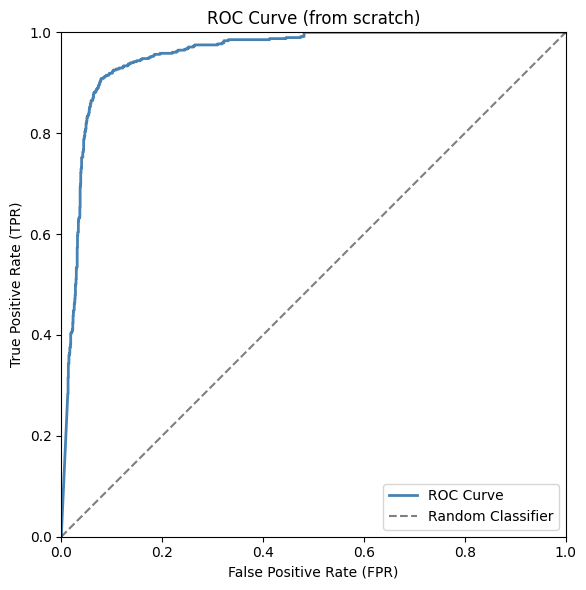

In [96]:
def compute_roc_curve(y_true, scores):
    """Compute ROC curve by sweeping the decision threshold."""
    # Sort thresholds in decreasing order
    thresholds = np.sort(np.unique(scores))[::-1]
    
    fprs = [0.0]
    tprs = [0.0]
    
    P = np.sum(y_true == 1)  # total actual positives
    N = np.sum(y_true == 0)  # total actual negatives
    
    for tau in thresholds:
        y_pred_tau = (scores >= tau).astype(int)
        tp = np.sum((y_true == 1) & (y_pred_tau == 1))
        fp = np.sum((y_true == 0) & (y_pred_tau == 1))
        tpr = tp / P
        fpr = fp / N
        tprs.append(tpr)
        fprs.append(fpr)
    
    return np.array(fprs), np.array(tprs)

fprs, tprs = compute_roc_curve(y_sms_test, y_sms_scores)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(fprs, tprs, color='steelblue', linewidth=2, label='ROC Curve')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('ROC Curve (from scratch)')
ax.legend()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

### Question 4.2: Compute AUC from Scratch Using the Trapezoidal Rule

The AUC is the area under the ROC curve. Compute it using the trapezoidal rule:

$$\text{AUC} = \sum_{k=1}^{K} \frac{1}{2}(\text{TPR}_{k-1} + \text{TPR}_k)(\text{FPR}_k - \text{FPR}_{k-1})$$

Verify with `sklearn.metrics.roc_auc_score`.

In [97]:
# AUC via trapezoidal rule
auc_scratch = 0.0
for k in range(1, len(fprs)):
    auc_scratch += 0.5 * (tprs[k - 1] + tprs[k]) * (fprs[k] - fprs[k - 1])

print(f"AUC (from scratch, trapezoidal rule): {auc_scratch:.4f}")

# Verify with numpy's trapz
auc_np = np.trapz(tprs, fprs)
print(f"AUC (np.trapz):                       {auc_np:.4f}")

# Verify with sklearn
from sklearn.metrics import roc_auc_score
auc_sk = roc_auc_score(y_sms_test, y_sms_scores)
print(f"AUC (sklearn):                        {auc_sk:.4f}")

AUC (from scratch, trapezoidal rule): 0.9558
AUC (np.trapz):                       0.9558
AUC (sklearn):                        0.9558


/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/1617931096.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_np = np.trapz(tprs, fprs)


**Interpretation:** An AUC significantly above 0.5 confirms that the classifier has discriminative power — it assigns higher scores to spam messages than to ham messages with high probability. An AUC of 1.0 would indicate perfect separation.

***

## Section 5: $k$-Fold Cross-Validation — From Scratch

**Theory Recap.** $k$-Fold CV partitions the dataset into $k$ disjoint folds. For each fold $i$, we train on all data except fold $i$ and evaluate on fold $i$. The final score is:

$$\text{CV}_k = \frac{1}{k} \sum_{i=1}^{k} M_i$$

This produces a more stable and representative estimate of generalization error than a single train/test split.

### Question 5.1: Implement $k$-Fold Cross-Validation from Scratch

Write a function that performs $k$-fold CV for linear regression using MSE as the evaluation metric. Apply it to the insurance dataset using `age` and `bmi` as predictors with $k = 5$.

In [98]:
def kfold_cv_linear_regression(X, y, k=5):
    """Perform k-fold cross-validation for OLS linear regression.
    
    X: design matrix with intercept column (n x (p+1))
    y: target vector (n,)
    k: number of folds
    
    Returns: array of per-fold MSE values
    """
    n = len(y)
    indices = np.random.permutation(n)
    fold_sizes = np.full(k, n // k, dtype=int)
    fold_sizes[:n % k] += 1  # distribute remainder
    
    fold_mses = []
    current = 0
    
    for i in range(k):
        # Define validation indices for this fold
        val_idx = indices[current:current + fold_sizes[i]]
        train_idx = np.concatenate([indices[:current], indices[current + fold_sizes[i]:]])
        current += fold_sizes[i]
        
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        # OLS fit
        beta = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
        y_pred_val = X_val @ beta
        
        # Compute MSE on validation fold
        mse_fold = np.mean((y_val - y_pred_val) ** 2)
        fold_mses.append(mse_fold)
        
        print(f"  Fold {i+1}: MSE = {mse_fold:,.2f}")
    
    return np.array(fold_mses)

# Prepare full data
X_full = np.column_stack([np.ones(n), df_insurance[['age', 'bmi']].values])
y_full = df_insurance['charges'].values

print("5-Fold CV for Linear Regression (age, bmi -> charges):")
fold_mses = kfold_cv_linear_regression(X_full, y_full, k=5)
print(f"\nCV_5 = mean(fold MSEs) = {np.mean(fold_mses):,.2f}")
print(f"Std of fold MSEs:        {np.std(fold_mses):,.2f}")

5-Fold CV for Linear Regression (age, bmi -> charges):
  Fold 1: MSE = 143,783,220.92
  Fold 2: MSE = 117,448,660.95
  Fold 3: MSE = 128,965,046.45
  Fold 4: MSE = 132,038,347.06
  Fold 5: MSE = 130,988,946.41

CV_5 = mean(fold MSEs) = 130,644,844.35
Std of fold MSEs:        8,386,157.31


/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:28: RuntimeWarning: divide by zero encountered in matmul
  beta = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:28: RuntimeWarning: overflow encountered in matmul
  beta = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:28: RuntimeWarning: invalid value encountered in matmul
  beta = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:29: RuntimeWarning: divide by zero encountered in matmul
  y_pred_val = X_val @ beta
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:29: RuntimeWarning: overflow encountered in matmul
  y_pred_val = X_val @ beta
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:29: RuntimeWarning: invalid value en

### Question 5.2: Model Selection via Cross-Validation

Use your $k$-fold CV implementation to compare polynomial regression models of degrees 1 through 5 on the insurance data (using `age` as the sole predictor for simplicity). Select the degree that minimizes the CV score.

In [99]:
age = df_insurance['age'].values
charges = df_insurance['charges'].values

degrees_to_test = [1, 2, 3, 4, 5]
cv_scores = []

for d in degrees_to_test:
    # Build polynomial design matrix: [1, x, x^2, ..., x^d]
    X_poly = np.column_stack([age ** j for j in range(d + 1)])
    
    print(f"\nDegree {d}:")
    fold_mses = kfold_cv_linear_regression(X_poly, charges, k=5)
    cv_score = np.mean(fold_mses)
    cv_scores.append(cv_score)
    print(f"  CV_5 (MSE) = {cv_score:,.2f}")

best_idx = np.argmin(cv_scores)
print(f"\n{'='*50}")
print(f"Best degree: d* = {degrees_to_test[best_idx]} with CV_5 = {cv_scores[best_idx]:,.2f}")


Degree 1:
  Fold 1: MSE = 132,287,699.59
  Fold 2: MSE = 152,570,936.54
  Fold 3: MSE = 134,233,005.62
  Fold 4: MSE = 121,169,089.74
  Fold 5: MSE = 132,689,491.55
  CV_5 (MSE) = 134,590,044.61

Degree 2:
  Fold 1: MSE = 117,116,723.04
  Fold 2: MSE = 145,651,917.95
  Fold 3: MSE = 138,153,333.16
  Fold 4: MSE = 131,162,331.77
  Fold 5: MSE = 141,188,928.64
  CV_5 (MSE) = 134,654,646.91

Degree 3:
  Fold 1: MSE = 133,662,570.33
  Fold 2: MSE = 138,884,316.45
  Fold 3: MSE = 141,274,425.06
  Fold 4: MSE = 119,250,343.39
  Fold 5: MSE = 139,044,048.73
  CV_5 (MSE) = 134,423,140.79

Degree 4:
  Fold 1: MSE = 124,656,057.95
  Fold 2: MSE = 133,475,403.51
  Fold 3: MSE = 139,667,403.87
  Fold 4: MSE = 144,872,593.11
  Fold 5: MSE = 130,787,826.15
  CV_5 (MSE) = 134,691,856.92

Degree 5:
  Fold 1: MSE = 146,671,234.67
  Fold 2: MSE = 136,350,590.26
  Fold 3: MSE = 133,376,078.41
  Fold 4: MSE = 132,685,058.09
  Fold 5: MSE = 123,547,762.21
  CV_5 (MSE) = 134,526,144.73

Best degree: d* = 3

/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:28: RuntimeWarning: divide by zero encountered in matmul
  beta = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:28: RuntimeWarning: overflow encountered in matmul
  beta = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:28: RuntimeWarning: invalid value encountered in matmul
  beta = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:29: RuntimeWarning: divide by zero encountered in matmul
  y_pred_val = X_val @ beta
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:29: RuntimeWarning: overflow encountered in matmul
  y_pred_val = X_val @ beta
/var/folders/tr/2pdj27553xqc8j9m9lzhqt8r0000gn/T/ipykernel_52154/3670292611.py:29: RuntimeWarning: invalid value en

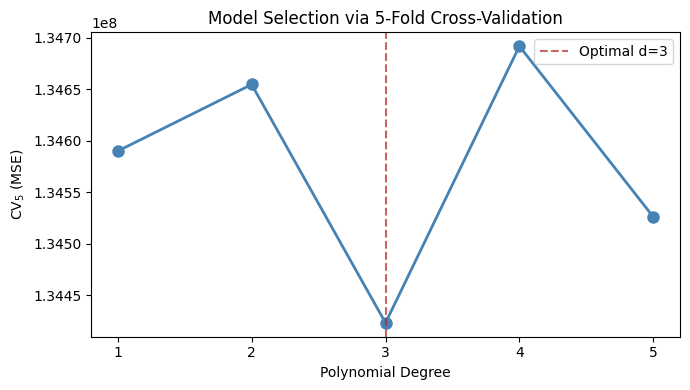

In [100]:
# Visualize CV scores vs. degree
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(degrees_to_test, cv_scores, 'o-', color='steelblue', linewidth=2, markersize=8)
ax.axvline(x=degrees_to_test[best_idx], linestyle='--', color='firebrick', 
           alpha=0.7, label=f'Optimal d={degrees_to_test[best_idx]}')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('CV$_5$ (MSE)')
ax.set_title('Model Selection via 5-Fold Cross-Validation')
ax.set_xticks(degrees_to_test)
ax.legend()
plt.tight_layout()
plt.show()

### Question 5.3: Verify with Scikit-learn's `cross_val_score`

Use `sklearn.model_selection.cross_val_score` with `LinearRegression` to confirm the from-scratch CV results for the best polynomial degree.

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

best_d = degrees_to_test[best_idx]

model = make_pipeline(
    PolynomialFeatures(degree=best_d, include_bias=False),
    LinearRegression()
)

# cross_val_score uses negative MSE by convention (higher is better)
scores_sk = cross_val_score(model, age.reshape(-1, 1), charges, 
                            cv=5, scoring='neg_mean_squared_error')

print(f"Sklearn 5-Fold CV (degree={best_d}):")
for i, s in enumerate(scores_sk):
    print(f"  Fold {i+1}: MSE = {-s:,.2f}")
print(f"  CV_5 (MSE) = {-np.mean(scores_sk):,.2f}")

Sklearn 5-Fold CV (degree=3):
  Fold 1: MSE = 128,946,926.06
  Fold 2: MSE = 131,859,280.37
  Fold 3: MSE = 145,119,698.34
  Fold 4: MSE = 128,134,921.27
  Fold 5: MSE = 139,990,523.77
  CV_5 (MSE) = 134,810,269.96


/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib

**Note:** The exact values may differ slightly from the scratch implementation due to different random fold partitions. The important point is that the *ranking* of models (which degree is best) should be consistent.

***

## Section 6: Synthesis — Full Evaluation Pipeline on the Insurance Dataset

In this final exercise, we bring together all the concepts from this workshop: we use cross-validation to select a model, train it on the full training set, and evaluate it with the complete suite of regression metrics.

### Question 6.1: End-to-End Regression Pipeline

1. Use all four numerical features (`age`, `bmi`, `children`, `smoker`) from the insurance dataset.
2. Perform 5-fold CV to compare a linear model (degree 1) vs. a quadratic model (degree 2) using all features.
3. Select the best model, retrain on the full training set, and report MSE, RMSE, $R^2$, and Adjusted $R^2$ on the held-out test set.
4. Produce a residual plot ($\hat{y}$ vs. residuals) to visually assess model quality.

In [102]:
from sklearn.model_selection import cross_val_score

# Prepare features
X_all = np.column_stack([
    df_insurance['age'].values,
    df_insurance['bmi'].values,
    df_insurance['children'].values,
    (df_insurance['smoker'] == 'yes').astype(int).values
])
y_all = df_insurance['charges'].values

# Compare degree 1 vs degree 2
for d in [1, 2]:
    model = make_pipeline(
        PolynomialFeatures(degree=d, include_bias=False),
        LinearRegression()
    )
    scores = cross_val_score(model, X_all, y_all, cv=5, scoring='neg_mean_squared_error')
    print(f"Degree {d}: CV_5(MSE) = {-np.mean(scores):,.2f} (+/- {np.std(-scores):,.2f})")

Degree 1: CV_5(MSE) = 37,034,506.54 (+/- 1,542,992.27)
Degree 2: CV_5(MSE) = 23,370,487.32 (+/- 1,429,883.77)


/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib

In [103]:
# Train best model on training set, evaluate on test set
X_tr_all, X_te_all = X_all[train_idx], X_all[test_idx]
y_tr_all, y_te_all = y_all[train_idx], y_all[test_idx]

best_model = make_pipeline(
    PolynomialFeatures(degree=1, include_bias=False),
    LinearRegression()
)
best_model.fit(X_tr_all, y_tr_all)
y_hat_final = best_model.predict(X_te_all)

# Compute all metrics
p_final = X_all.shape[1]
mse_final = compute_mse(y_te_all, y_hat_final)
rmse_final = np.sqrt(mse_final)
r2_final = compute_r2(y_te_all, y_hat_final)
adj_r2_final = compute_adj_r2(y_te_all, y_hat_final, p_final)

print(f"Final Model Evaluation (Test Set):")
print(f"  MSE:          {mse_final:,.2f}")
print(f"  RMSE:         {rmse_final:,.2f}")
print(f"  R^2:          {r2_final:.4f}")
print(f"  Adj. R^2:     {adj_r2_final:.4f}")

Final Model Evaluation (Test Set):
  MSE:          40,094,311.01
  RMSE:         6,332.01
  R^2:          0.7388
  Adj. R^2:     0.7369


/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/epsilonxe/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


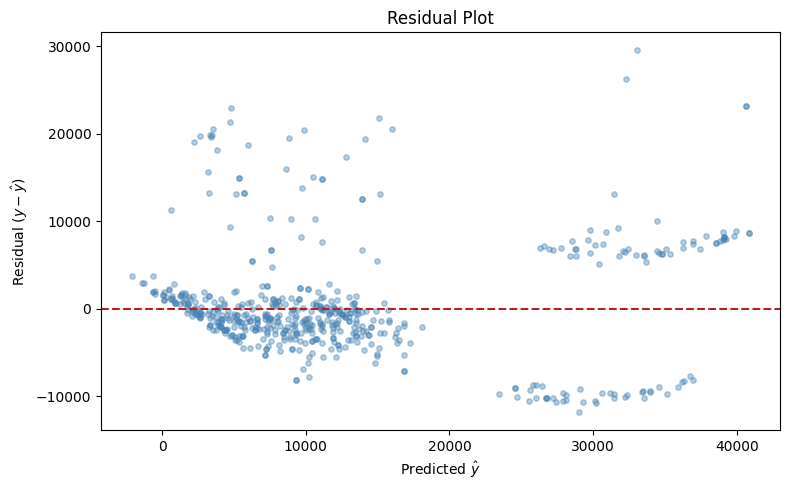

In [104]:
# Residual plot
residuals = y_te_all - y_hat_final

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(y_hat_final, residuals, alpha=0.4, s=15, color='steelblue')
ax.axhline(y=0, color='firebrick', linestyle='--', linewidth=1.5)
ax.set_xlabel(r'Predicted $\hat{y}$')
ax.set_ylabel(r'Residual ($y - \hat{y}$)')
ax.set_title('Residual Plot')
plt.tight_layout()
plt.show()

**Interpretation:** The residual plot reveals whether the model's errors are randomly distributed (good) or exhibit systematic patterns (indicating model misspecification). A funnel shape suggests heteroscedasticity — the model's errors grow with the predicted value. Clusters or curves suggest the linear model fails to capture important non-linear relationships in the data.

***